
<img style="float: left; padding-right: 10px; width: 45px" src="https://upload.wikimedia.org/wikipedia/fr/b/b1/Logo_EPF.png?raw=true"> 

# Introduction to Machine Learning
**P2023: Data engineering**<br>


## Lab 3:  Regularized linear models

### First name: Maxime
### Last name: Raillat
### Group: A1


---

# Introduction
As we have seen during the course, **overfitting** is one of the most frequent issues we have to deal with while working on machine learning tasks. 

Overfitting refers to the scenario where a machine learning model can’t **generalize** or fit well on unseen data. It refers to a modeling error that occurs when a function corresponds too closely to a dataset. As a result, overfitting models may fail to fit additional data, and this may affect the accuracy of predicting future observations.

One way to avoid overfitting is to use **regularization**. It consists of adding a **penalty** term to the loss function we want to minimize. By doing this, we penalize the learning of complex models and encourage the learning of simpler models.

Another way of avoiding overfitting is to use proper **cross-validation** techniques in order to have an accurate estimation of the **generalization power** of our model (i.e how well it will perform on unseen data)

In this lab, we'll look at Ridge and Lasso regularization techniques for a logistic regression model. We will also see why it's important to use cross-validation when tuning the model's hyperparameters.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

/tmp/ipykernel_21255/260421466.py:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


##Dataset description
We will use [The Ames Housing dataset](http://jse.amstat.org/v19n3/decock.pdf) which is describing the sale of individual residential property in Ames, Iowa from 2006 to 2010. The data set contains 2930 observations and a large number of explanatory variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous) involved in assessing home values.

Take a look at the data_description.txt file to see a description of each of these explanatory variables.

In [3]:
# read in data
data = pd.read_csv("data.csv")


In [4]:
# show the data size
data.shape[0]


1460

In [5]:
# split to 80% train data and 20% test data
y = data["SalePrice"]
X = data.drop('SalePrice', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=27)

In [6]:
# have a look at the data
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Data preprocessing: 

**Exercise :** Plot the distribution of the price variable

array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

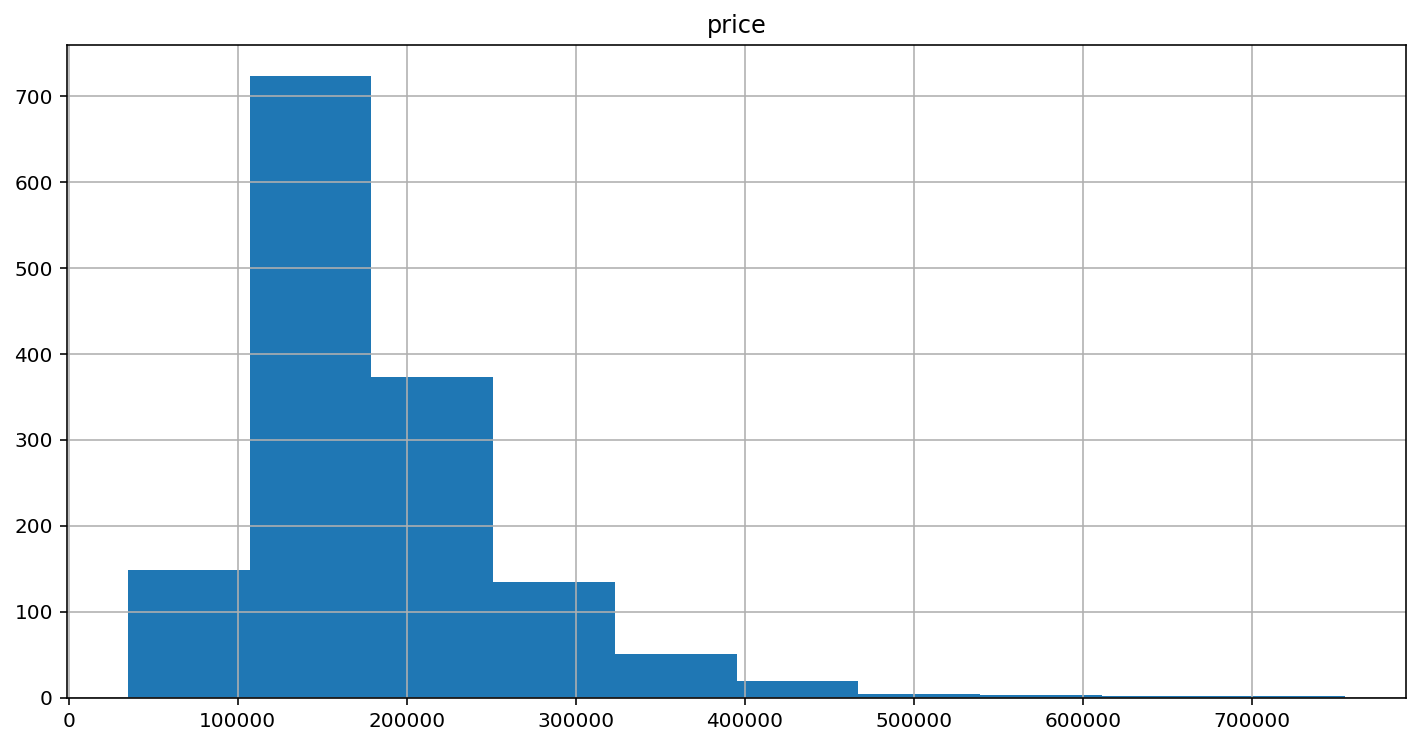

In [7]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":data["SalePrice"]})
prices.hist()

We can see that the distribution is highly skewed to the left. As we have seen in the feature engineering class, one way to deal with the skewness is to apply a log transformation to be as close to a normal distribution as possible.

**Exercise :** Plot the distribution of the log of the price variable, you can use the log1p numpy function.

array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

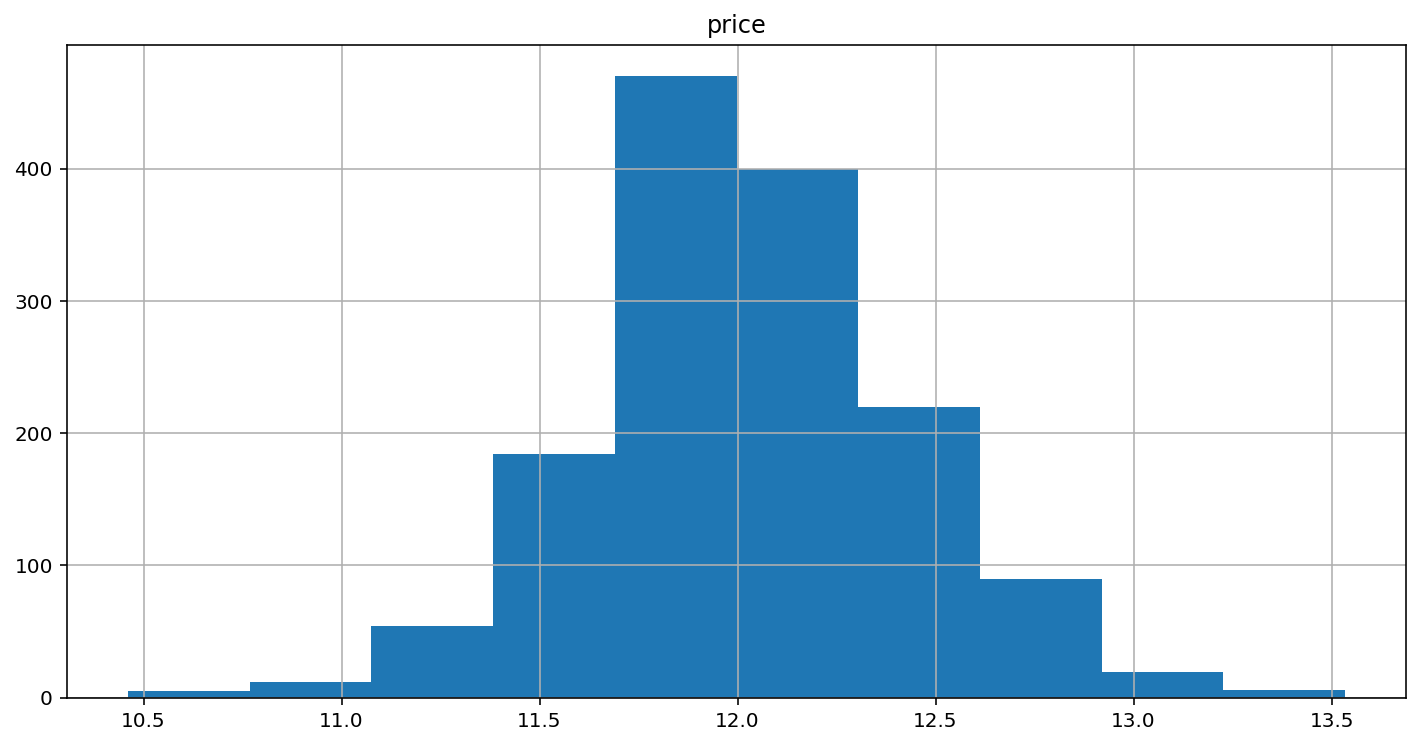

In [8]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":np.log1p(data["SalePrice"])})
prices.hist()

In [9]:
# concatenate train and test data before transformation
all_data = pd.concat((X_train.loc[:,'MSSubClass':'SaleCondition'],
                      X_test.loc[:,'MSSubClass':'SaleCondition']))

In [10]:
#log transform the target:
y_train= np.log1p(y_train)
y_test= np.log1p(y_test)

#log transform skewed numeric features (skewness > 0.75):
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = X_train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [11]:
## Create dummy variables
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)


In [21]:
for column in numeric_feats:
    X_train[column]= X_train[column].fillna(value=X_train[column].mean())
y_train= y_train.fillna(value=y_train.mean())

1168

In [23]:
#create matrices for sklearn:
X_train = all_data[:X_train.shape[0]]
X_test = all_data[X_train.shape[0]:]
y_train = y_train
y_test = y_test

### Models


Ridge model is a regression model where the loss function is the linear least squares function and regularization is given by the l2-norm.
The objective function is given by: 
$$ {||y - Xw||^2_2 + alpha * ||w||^2_2 }$$

The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data.

In [24]:
model_ridge = Ridge()

**Exercise**: Perform a grid search in which you try different values of alpha and where the goal is to have the lowest RMSE on the train dataset.

The values to use for alpha are: 
0, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75


In [28]:
## Function to compute the RMSE on the train dataset
def compute_train_rmse(model):
    model.fit(X_train,y_train)
    rmse = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
    return(rmse)

**Exercise**: Plot the train RMSE for the different values of alpha.

Which value gives the best (lowest) RMSE ?



Which alpha yields the best model ?

Now let's see how this holds on the test data.

**Exercise**: Instead of evaluating on the train data, now evaluate the RMSE on the test data.

In [ ]:
## Function to compute the RMSE on the test dataset
def compute_test_rmse(model):
    model.fit(X_train,y_train)
    rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    return(rmse)

**Exercise**: Plot the test RMSE for the different values of alpha.

How does the best performing alpha on training test perform on the test set? What happened?

**Importance of cross-validation**

Let's now perform the grid search while using cross-validation to evaluate our models. For this, you can use the cross_val_score function that is provided by scikit-learn.

In [ ]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data.

In [ ]:
##Plot the cross-validation result without the first alpha value (0)


Note the U-ish shaped curve above. When alpha is too large the regularization is too strong and the model cannot capture all the complexities in the data. If however we let the model be too flexible (alpha small) the model begins to overfit. A value of alpha = 10 is about right based on the plot above.

Let' try out the Lasso model. We will do a slightly different approach here and use the built in Lasso CV to figure out the best alpha for us. 


The lasso performs even better so we'll just use this one to predict on the test set. Another good thing about the Lasso is that it does feature selection for you - setting coefficients of features it deems unimportant to zero. Let's take a look at the coefficients:

We can also take a look directly at what the most important coefficients are: